# ---- EXPLORATORY DATA ANALYSIS (EDA) ----

### >>> Librerías

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from folium import plugins

### >>> Cargue de fuentes de datos

In [2]:
df_vh = pd.read_csv('./Datasets/ETL/victimas_hechos.csv') 

In [3]:
df_vh.shape

(717, 30)

In [4]:
df_vh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   EDAD_VICTIMA           717 non-null    object 
 1   FECHA_x                717 non-null    object 
 2   FECHA_AA               717 non-null    int64  
 3   FECHA_DD               717 non-null    int64  
 4   FECHA_DECESO           717 non-null    object 
 5   FECHA_MM               717 non-null    int64  
 6   ID                     717 non-null    object 
 7   ROL_VICTIMA            717 non-null    object 
 8   SEXO_VICTIMA           717 non-null    object 
 9   VH_VICTIMA             717 non-null    object 
 10  AAAA                   717 non-null    int64  
 11  Altura                 133 non-null    float64
 12  Calle                  716 non-null    object 
 13  COMUNA                 717 non-null    int64  
 14  Cruce                  540 non-null    object 
 15  DD    

In [5]:
df_vh.describe()

,FECHA_AA,FECHA_DD,FECHA_MM,AAAA,Altura,COMUNA,DD,MM,N_VICTIMAS
count,717.000000,717.000000,717.000000,717.000000,133.000000,717.000000,717.000000,717.000000,717.000000
mean,2018.174338,15.960948,6.688982,2018.174338,3384.187970,7.430962,15.953975,6.688982,1.061367
std,1.672655,8.683358,3.575140,1.672655,3095.161836,4.385067,8.674876,3.575140,0.257024
min,2016.000000,1.000000,1.000000,2016.000000,30.000000,0.000000,1.000000,1.000000,1.000000
25%,2017.000000,9.000000,4.000000,2017.000000,1366.000000,4.000000,9.000000,4.000000,1.000000
50%,2018.000000,16.000000,7.000000,2018.000000,2639.000000,8.000000,16.000000,7.000000,1.000000
75%,2019.000000,23.000000,10.000000,2019.000000,4500.000000,11.000000,23.000000,10.000000,1.000000
max,2021.000000,31.000000,12.000000,2021.000000,16080.000000,15.000000,31.000000,12.000000,3.000000


## 0. Prueba de Operación

### 0.1 Sobre datos de Frecuencia 

In [6]:
df_vh_faa = df_vh.groupby(['FECHA_AA']).size().reset_index(name='count')
df_vh_faa.head(6)

,FECHA_AA,count
0,2016,146
1,2017,140
2,2018,149
3,2019,104
4,2020,81
5,2021,97


In [7]:
df_vh_fmm = df_vh.groupby(['FECHA_AA', 'FECHA_MM']).size().reset_index(name='count')
df_vh_fmm.head(5)

,FECHA_AA,FECHA_MM,count
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7


In [8]:
df_vh_fcs = df_vh.groupby(['COMUNA', 'SEXO_VICTIMA']).size().reset_index(name='count')
df_vh_fcs.head(10)

,COMUNA,SEXO_VICTIMA,count
0,0,SD,2
1,1,FEMENINO,16
2,1,MASCULINO,76
3,1,SD,1
4,2,FEMENINO,7
5,2,MASCULINO,18
6,3,FEMENINO,14
7,3,MASCULINO,32
8,4,FEMENINO,16
9,4,MASCULINO,61


## 1. Visualización de Datos Geoespaciales

In [9]:
# ---> Tratamiento de los datos contenidos en las columnas 'POSY' y 'POSX' 
df_vh['POSY'] = pd.to_numeric(df_vh['POSY'], errors='coerce')
df_vh['POSY'] = df_vh['POSY'].replace('.', pd.NA, regex=True)
df_vh['POSX'] = pd.to_numeric(df_vh['POSX'], errors='coerce')
df_vh['POSX'] = df_vh['POSX'].replace('.', pd.NA, regex=True)

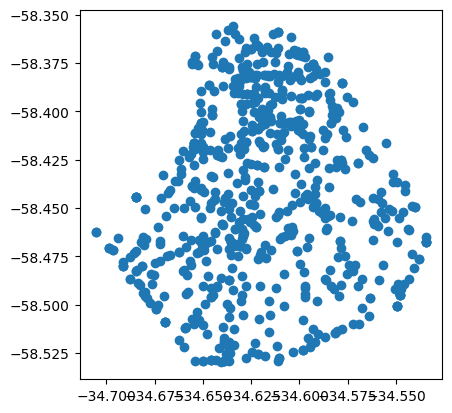

In [10]:
# ---> Creación de la columna 'localizador' para almacenar las coordenadas: 'latitud' (POSY), 'longitud' (POSX)
df_vh['localizador'] = df_vh.apply(lambda row: f"{row['POSY']}, {row['POSX']}", axis=1)

# ---> Conversión de coordenadas a elementos tipo Point
df_vh['geometry'] = df_vh['localizador'].apply(lambda x: Point(map(float, x.split(', '))))
df_vhgeolocalizador = gpd.GeoDataFrame(df_vh, geometry='geometry')
df_vhgeolocalizador.plot()
plt.show()

In [13]:
# ---> Cálcula del promedio  de 'POSY' y 'POSX' para localizar geográficamente el mapa
POSY_c = df_vh['POSY'].mean()
POSX_c = df_vh['POSX'].mean()


m = folium.Map(location=[POSY_c, POSX_c], zoom_start=12)        # ---> Generación del mapa

# ---> Iteración sobre el DataFrame para definir coordenadas válidas
for index, row in df_vh.iterrows():
    coordinates = row['localizador']  
    if pd.notnull(coordinates):
        lat, lon = coordinates.split(', ')
        try:
            lat, lon = float(lat), float(lon)
            folium.Marker(location=[lat, lon]).add_to(m)
        except ValueError:
            print(f"Coordenada geoespacial inválida: {coordinates}")        # ---> Impresión por pantalla del puntos geoespaciales inválidos

m


Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan
Coordenada geoespacial inválida: nan, nan


## 2. Filtración para uso de variables de interés

`Las variables de interés son agrupadas de acuerdo a su potencial oferta de información:`
* a. De acuerdo a su Frecuencia. Ej : Fatalidades por unidad de tiempo.
* b. De acuerdo a su carácter Demográfico. Ej: Fatalidades en función de género y/o edad.
* c. De acuerdo a su localización. Ej: Fatalidades en función del lugar de ocurrencia.
* d. De acuerdo a su Modo. Ej: Fatalidades en función del medio de transporte involucrado.
